In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io 
import random
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import seaborn as sn
import pandas as pd
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

In [2]:
train_dl_origin = torch.load('train_dl.pt')
valid_dl_origin = torch.load('valid_dl.pt')

train_CSI = train_dl_origin.dataset[:][0]
train_label = train_dl_origin.dataset[:][1][:,2].type(torch.LongTensor)

valid_CSI = valid_dl_origin.dataset[:][0]
valid_label = valid_dl_origin.dataset[:][1][:,2].type(torch.LongTensor)

In [3]:
train_CSI_modulus = torch.abs(train_CSI)
valid_CSI_modulus = torch.abs(valid_CSI)

In [4]:
print(train_CSI_modulus.shape)
print(valid_CSI_modulus.shape)

torch.Size([15000, 1, 4, 1632])
torch.Size([5000, 1, 4, 1632])


In [5]:
max_value_train = torch.max(train_CSI_modulus)
min_value_train = torch.min(train_CSI_modulus)
range_value = max_value_train - min_value_train

train_CSI_normalize = (train_CSI_modulus - min_value_train)/range_value
valid_CSI_normalize = (valid_CSI_modulus - min_value_train)/range_value

In [8]:
# Time domain CSI
train_CSI_time = torch.fft.ifft(train_CSI, n=1632, dim=-1)
valid_CSI_time = torch.fft.ifft(valid_CSI, n=1632, dim=-1)

# Total power of the CSI signal
train_CSI_power = torch.sum(train_CSI_modulus**2, dim=-1)
valid_CSI_power = torch.sum(valid_CSI_modulus**2, dim=-1)

In [9]:
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4*1632, 512)  # 4*1632 input nodes, 512 output nodes
        self.fc2 = nn.Linear(512, 128)     # 512 input nodes, 128 output nodes
        self.fc3 = nn.Linear(128, 2)       # 128 input nodes, 2 output nodes (LoS and NLoS)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

X_train = train_CSI_normalize.view(-1, 4*1632)  # Reshaping into 2D
y_train = train_label
X_valid = valid_CSI_normalize.view(-1, 4*1632)
y_valid = valid_label

# Training
for epoch in range(20):  
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{20}, Loss: {loss.item()}')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_valid)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_valid).sum().item() / y_valid.size(0)
    print(f'Validation Accuracy: {accuracy * 100}%')


Epoch 1/20, Loss: 0.6771837472915649
Epoch 2/20, Loss: 0.6764504313468933
Epoch 3/20, Loss: 0.6757169365882874
Epoch 4/20, Loss: 0.6749836206436157
Epoch 5/20, Loss: 0.6742511987686157
Epoch 6/20, Loss: 0.6735199689865112
Epoch 7/20, Loss: 0.6727906465530396
Epoch 8/20, Loss: 0.672063946723938
Epoch 9/20, Loss: 0.6713398694992065
Epoch 10/20, Loss: 0.6706184148788452
Epoch 11/20, Loss: 0.6698998212814331
Epoch 12/20, Loss: 0.6691847443580627
Epoch 13/20, Loss: 0.6684744358062744
Epoch 14/20, Loss: 0.6677690744400024
Epoch 15/20, Loss: 0.667068362236023
Epoch 16/20, Loss: 0.6663719415664673
Epoch 17/20, Loss: 0.6656796932220459
Epoch 18/20, Loss: 0.6649920344352722
Epoch 19/20, Loss: 0.6643086671829224
Epoch 20/20, Loss: 0.6636289954185486
Validation Accuracy: 81.28%


Epoch 1/20, Loss: 0.662952721118927
Epoch 2/20, Loss: 0.6622796654701233
Epoch 3/20, Loss: 0.6616100072860718
Epoch 4/20, Loss: 0.6609437465667725
Epoch 5/20, Loss: 0.6602806448936462
Epoch 6/20, Loss: 0.6596208810806274
Epoch 7/20, Loss: 0.658964216709137
Epoch 8/20, Loss: 0.65831059217453
Epoch 9/20, Loss: 0.6576603055000305
Epoch 10/20, Loss: 0.6570131778717041
Epoch 11/20, Loss: 0.6563690900802612
Epoch 12/20, Loss: 0.6557280421257019
Epoch 13/20, Loss: 0.6550898551940918
Epoch 14/20, Loss: 0.6544544100761414
Epoch 15/20, Loss: 0.6538214683532715
Epoch 16/20, Loss: 0.6531909704208374
Epoch 17/20, Loss: 0.65256267786026
Epoch 18/20, Loss: 0.6519364714622498
Epoch 19/20, Loss: 0.6513126492500305
Epoch 20/20, Loss: 0.6506910920143127


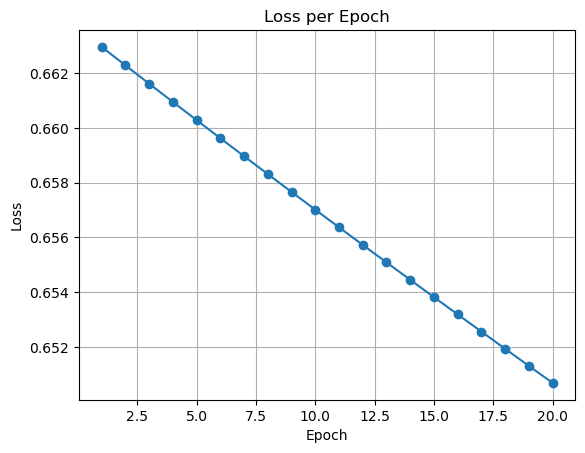

Validation Accuracy: 81.28%


In [10]:
loss_values = []

for epoch in range(20):  
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    loss_values.append(loss.item())  # Store the loss value
    print(f'Epoch {epoch+1}/{20}, Loss: {loss.item()}')

# Plotting the loss for each epoch
plt.plot(range(1, 21), loss_values, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_valid)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_valid).sum().item() / y_valid.size(0)
    print(f'Validation Accuracy: {accuracy * 100}%')

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 512)  # 1 input node, 512 output nodes
        self.fc2 = nn.Linear(512, 128)  # 512 input nodes, 128 output nodes
        self.fc3 = nn.Linear(128, 2)  # 128 input nodes, 2 output nodes (LoS and NLoS)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 1/20, Loss: 13543132.0
Epoch 2/20, Loss: 8.763761680483107e+22
Epoch 3/20, Loss: 11242316.0
Epoch 4/20, Loss: 2897017.25
Epoch 5/20, Loss: 0.7024543881416321
Epoch 6/20, Loss: 0.7022234797477722
Epoch 7/20, Loss: 0.7019927501678467
Epoch 8/20, Loss: 0.7017624974250793
Epoch 9/20, Loss: 0.701532244682312
Epoch 10/20, Loss: 0.7013025283813477
Epoch 11/20, Loss: 0.7010726928710938
Epoch 12/20, Loss: 0.7008432149887085
Epoch 13/20, Loss: 0.7006141543388367
Epoch 14/20, Loss: 0.7003853917121887
Epoch 15/20, Loss: 0.7001568078994751
Epoch 16/20, Loss: 0.6999281644821167
Epoch 17/20, Loss: 0.6997001767158508
Epoch 18/20, Loss: 0.6994720101356506
Epoch 19/20, Loss: 0.6992443203926086
Epoch 20/20, Loss: 0.6990171670913696
Validation Accuracy with Power of CSI as Input: 18.72%
Epoch 1/20, Loss: 0.6987897753715515
Epoch 2/20, Loss: 0.698562741279602
Epoch 3/20, Loss: 0.698336124420166
Epoch 4/20, Loss: 0.6981096267700195
Epoch 5/20, Loss: 0.6978834867477417
Epoch 6/20, Loss: 0.6976574063301

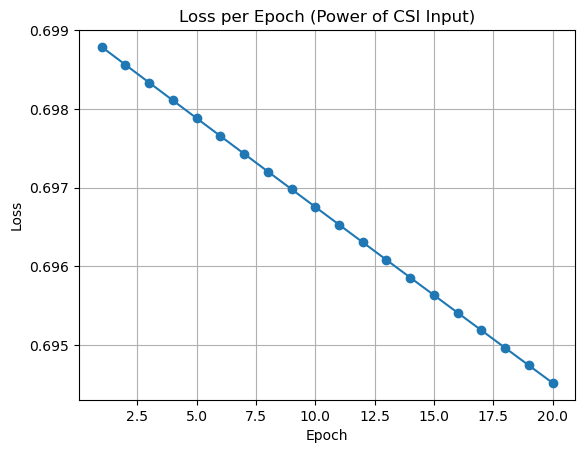

Validation Accuracy with Power of CSI as Input: 18.72%


In [15]:
# Power of CSI as INPUT

# Reshape the data to 2D and sum the power across the antennas and sub-carriers for each sample
X_train_power = train_CSI_power.sum(dim=[1, 2]).view(-1, 1)
X_valid_power = valid_CSI_power.sum(dim=[1, 2]).view(-1, 1)

model_power = Net()
optimizer = optim.SGD(model_power.parameters(), lr=0.001)


for epoch in range(20): 
    optimizer.zero_grad()
    outputs = model_power(X_train_power)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{20}, Loss: {loss.item()}')

model_power.eval()
with torch.no_grad():
    outputs = model_power(X_valid_power)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_valid).sum().item() / y_valid.size(0)
    print(f'Validation Accuracy with Power of CSI as Input: {accuracy * 100}%')
    
    
loss_values_power = []

for epoch in range(20): 
    optimizer.zero_grad()
    outputs = model_power(X_train_power)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    loss_values_power.append(loss.item())
    print(f'Epoch {epoch+1}/{20}, Loss: {loss.item()}')

plt.plot(range(1, 21), loss_values_power, marker='o')
plt.title('Loss per Epoch (Power of CSI Input)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

model_power.eval()
with torch.no_grad():
    outputs = model_power(X_valid_power)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_valid).sum().item() / y_valid.size(0)
    print(f'Validation Accuracy with Power of CSI as Input: {accuracy * 100}%')

In [16]:
from sklearn.decomposition import PCA

# Reshape data for PCA
train_CSI_reshaped = train_CSI_modulus.view(train_CSI_modulus.size(0), -1)
valid_CSI_reshaped = valid_CSI_modulus.view(valid_CSI_modulus.size(0), -1)

pca = PCA(n_components=50)  # Adjust number of components as needed
train_CSI_pca = pca.fit_transform(train_CSI_reshaped)
valid_CSI_pca = pca.transform(valid_CSI_reshaped)

# Convert back to tensors
train_CSI_pca = torch.tensor(train_CSI_pca, dtype=torch.float32)
valid_CSI_pca = torch.tensor(valid_CSI_pca, dtype=torch.float32)

In [14]:
# Reshape PCA data for input
X_train_pca = train_CSI_pca.view(-1, 50)  # Assuming PCA reduced to 50 features
X_valid_pca = valid_CSI_pca.view(-1, 50)

# Redefine network to match PCA feature size
class NetPCA(nn.Module):
    def __init__(self):
        super(NetPCA, self).__init__()
        self.fc1 = nn.Linear(50, 128)  # Adjusted for PCA feature size
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_pca = NetPCA()
optimizer_pca = optim.SGD(model_pca.parameters(), lr=0.001)

# Training with PCA data
for epoch in range(20):
    optimizer_pca.zero_grad()
    outputs_pca = model_pca(X_train_pca)
    loss_pca = criterion(outputs_pca, y_train)
    loss_pca.backward()
    optimizer_pca.step()
    print(f'Epoch {epoch+1}/20, Loss: {loss_pca.item()}')

# Evaluation with PCA data
model_pca.eval()
with torch.no_grad():
    outputs_pca = model_pca(X_valid_pca)
    _, predicted_pca = torch.max(outputs_pca, 1)
    accuracy_pca = (predicted_pca == y_valid).sum().item() / y_valid.size(0)
    print(f'Validation Accuracy with PCA: {accuracy_pca * 100}%')

Epoch 1/20, Loss: 145.0203094482422
Epoch 2/20, Loss: 3935.19140625
Epoch 3/20, Loss: 26.591720581054688
Epoch 4/20, Loss: 329.6529235839844
Epoch 5/20, Loss: 2193.426513671875
Epoch 6/20, Loss: 2490.83056640625
Epoch 7/20, Loss: 20892.44921875
Epoch 8/20, Loss: 1494.981689453125
Epoch 9/20, Loss: 9.928051948547363
Epoch 10/20, Loss: 1.5525249242782593
Epoch 11/20, Loss: 0.9559106826782227
Epoch 12/20, Loss: 0.8833277225494385
Epoch 13/20, Loss: 0.8621588349342346
Epoch 14/20, Loss: 0.8448821902275085
Epoch 15/20, Loss: 0.8301998972892761
Epoch 16/20, Loss: 0.8184568881988525
Epoch 17/20, Loss: 0.8097965121269226
Epoch 18/20, Loss: 0.8027772307395935
Epoch 19/20, Loss: 0.7967715263366699
Epoch 20/20, Loss: 0.7912434339523315
Validation Accuracy with PCA: 18.82%


Epoch 1/20, Loss: 267.60546875
Epoch 2/20, Loss: 3911.879150390625
Epoch 3/20, Loss: 90.8480224609375
Epoch 4/20, Loss: 9886.7060546875
Epoch 5/20, Loss: 2947.2431640625
Epoch 6/20, Loss: 896352.8125
Epoch 7/20, Loss: 7.9246602058410645
Epoch 8/20, Loss: 1113.7786865234375
Epoch 9/20, Loss: 184.4055633544922
Epoch 10/20, Loss: 16.983232498168945
Epoch 11/20, Loss: 578.4481201171875
Epoch 12/20, Loss: 1.475141167640686
Epoch 13/20, Loss: 1.1781632900238037
Epoch 14/20, Loss: 1.0660738945007324
Epoch 15/20, Loss: 0.9993093013763428
Epoch 16/20, Loss: 0.9444507956504822
Epoch 17/20, Loss: 0.9037563800811768
Epoch 18/20, Loss: 0.8706405758857727
Epoch 19/20, Loss: 0.8453689813613892
Epoch 20/20, Loss: 0.8285111784934998


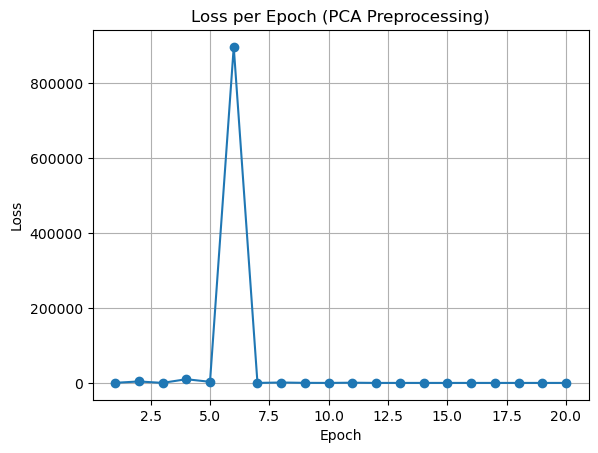

Validation Accuracy with PCA: 22.1%


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reshape data for PCA
train_CSI_reshaped = train_CSI_modulus.view(train_CSI_modulus.size(0), -1)
valid_CSI_reshaped = valid_CSI_modulus.view(valid_CSI_modulus.size(0), -1)

pca = PCA(n_components=50)
train_CSI_pca = pca.fit_transform(train_CSI_reshaped)
valid_CSI_pca = pca.transform(valid_CSI_reshaped)

train_CSI_pca = torch.tensor(train_CSI_pca, dtype=torch.float32)
valid_CSI_pca = torch.tensor(valid_CSI_pca, dtype=torch.float32)

X_train_pca = train_CSI_pca
X_valid_pca = valid_CSI_pca

# Redefine NN for PCA
class NetPCA(nn.Module):
    def __init__(self):
        super(NetPCA, self).__init__()
        self.fc1 = nn.Linear(50, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_pca = NetPCA()
optimizer_pca = optim.SGD(model_pca.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values_pca = []

for epoch in range(20):
    optimizer_pca.zero_grad()
    outputs_pca = model_pca(X_train_pca)
    loss_pca = criterion(outputs_pca, y_train)
    loss_pca.backward()
    optimizer_pca.step()
    
    loss_values_pca.append(loss_pca.item())
    print(f'Epoch {epoch+1}/20, Loss: {loss_pca.item()}')

plt.plot(range(1, 21), loss_values_pca, marker='o')
plt.title('Loss per Epoch (PCA Preprocessing)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

model_pca.eval()
with torch.no_grad():
    outputs_pca = model_pca(X_valid_pca)
    _, predicted_pca = torch.max(outputs_pca, 1)
    accuracy_pca = (predicted_pca == y_valid).sum().item() / y_valid.size(0)
    print(f'Validation Accuracy with PCA: {accuracy_pca * 100}%')

In [15]:
# Standardization

mean_train = torch.mean(train_CSI_modulus)
std_train = torch.std(train_CSI_modulus)

train_CSI_standardized = (train_CSI_modulus - mean_train) / std_train
valid_CSI_standardized = (valid_CSI_modulus - mean_train) / std_train

In [17]:
# Reshape standardized data for input
X_train_standardized = train_CSI_standardized.view(-1, 4*1632)
X_valid_standardized = valid_CSI_standardized.view(-1, 4*1632)

# Use the original network
model_standardized = Net()
optimizer_standardized = optim.SGD(model_standardized.parameters(), lr=0.001)

# Training with standardized data
for epoch in range(30):
    optimizer_standardized.zero_grad()
    outputs_standardized = model_standardized(X_train_standardized)
    loss_standardized = criterion(outputs_standardized, y_train)
    loss_standardized.backward()
    optimizer_standardized.step()
    print(f'Epoch {epoch+1}/30, Loss: {loss_standardized.item()}')

# Evaluation with standardized data
model_standardized.eval()
with torch.no_grad():
    outputs_standardized = model_standardized(X_valid_standardized)
    _, predicted_standardized = torch.max(outputs_standardized, 1)
    accuracy_standardized = (predicted_standardized == y_valid).sum().item() / y_valid.size(0)
    print(f'Validation Accuracy with Standardized Data: {accuracy_standardized * 100}%')

Epoch 1/20, Loss: 0.6840701699256897
Epoch 2/20, Loss: 0.6742150783538818
Epoch 3/20, Loss: 0.6646415591239929
Epoch 4/20, Loss: 0.6553259491920471
Epoch 5/20, Loss: 0.6462458968162537
Epoch 6/20, Loss: 0.6373783349990845
Epoch 7/20, Loss: 0.628763735294342
Epoch 8/20, Loss: 0.6204264760017395
Epoch 9/20, Loss: 0.6123649477958679
Epoch 10/20, Loss: 0.604576826095581
Epoch 11/20, Loss: 0.597058117389679
Epoch 12/20, Loss: 0.5898163318634033
Epoch 13/20, Loss: 0.5828463435173035
Epoch 14/20, Loss: 0.5761410593986511
Epoch 15/20, Loss: 0.569690465927124
Epoch 16/20, Loss: 0.5634922385215759
Epoch 17/20, Loss: 0.5575315952301025
Epoch 18/20, Loss: 0.5517992973327637
Epoch 19/20, Loss: 0.5462875366210938
Epoch 20/20, Loss: 0.5409925580024719
Epoch 21/20, Loss: 0.5359073281288147
Epoch 22/20, Loss: 0.5310229659080505
Epoch 23/20, Loss: 0.5263331532478333
Epoch 24/20, Loss: 0.5218322277069092
Epoch 25/20, Loss: 0.5175163149833679
Epoch 26/20, Loss: 0.5133764743804932
Epoch 27/20, Loss: 0.5094

Epoch 1/30, Loss: 0.6910590529441833
Epoch 2/30, Loss: 0.677556037902832
Epoch 3/30, Loss: 0.6652286648750305
Epoch 4/30, Loss: 0.6539737582206726
Epoch 5/30, Loss: 0.6436967253684998
Epoch 6/30, Loss: 0.634270429611206
Epoch 7/30, Loss: 0.6255815625190735
Epoch 8/30, Loss: 0.6175114512443542
Epoch 9/30, Loss: 0.6099755167961121
Epoch 10/30, Loss: 0.6029123067855835
Epoch 11/30, Loss: 0.5962615609169006
Epoch 12/30, Loss: 0.5899828672409058
Epoch 13/30, Loss: 0.5840359330177307
Epoch 14/30, Loss: 0.5783841013908386
Epoch 15/30, Loss: 0.573002278804779
Epoch 16/30, Loss: 0.567858874797821
Epoch 17/30, Loss: 0.5629363059997559
Epoch 18/30, Loss: 0.5582160353660583
Epoch 19/30, Loss: 0.5536840558052063
Epoch 20/30, Loss: 0.5493302941322327
Epoch 21/30, Loss: 0.5451429486274719
Epoch 22/30, Loss: 0.5411162972450256
Epoch 23/30, Loss: 0.5372388958930969
Epoch 24/30, Loss: 0.5335017442703247
Epoch 25/30, Loss: 0.5298942923545837
Epoch 26/30, Loss: 0.5264060497283936
Epoch 27/30, Loss: 0.5230

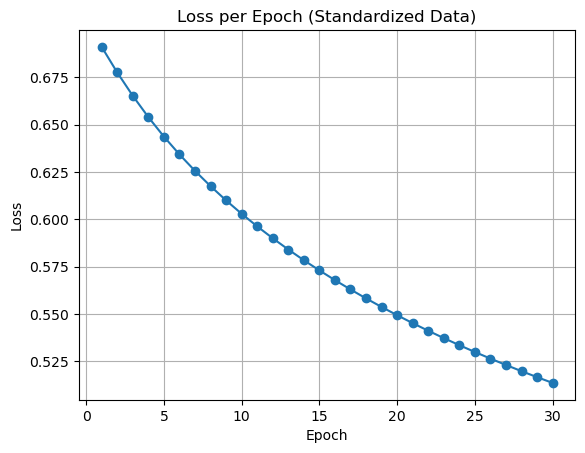

Validation Accuracy with Standardized Data: 81.28%


In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4*1632, 512)  # Adjusted to 4*1632 input nodes
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Assuming the rest of your code remains the same

# Use the original network with corrected input size
model_standardized = Net()
optimizer_standardized = optim.SGD(model_standardized.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Store loss values
loss_values_standardized = []

# Training with standardized data
for epoch in range(30):
    optimizer_standardized.zero_grad()
    outputs_standardized = model_standardized(X_train_standardized)
    loss_standardized = criterion(outputs_standardized, y_train)
    loss_standardized.backward()
    optimizer_standardized.step()
    
    loss_values_standardized.append(loss_standardized.item())
    print(f'Epoch {epoch+1}/30, Loss: {loss_standardized.item()}')

# Plotting the loss for each epoch
plt.plot(range(1, 31), loss_values_standardized, marker='o')
plt.title('Loss per Epoch (Standardized Data)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluation with standardized data
model_standardized.eval()
with torch.no_grad():
    outputs_standardized = model_standardized(X_valid_standardized)
    _, predicted_standardized = torch.max(outputs_standardized, 1)
    accuracy_standardized = (predicted_standardized == y_valid).sum().item() / y_valid.size(0)
    print(f'Validation Accuracy with Standardized Data: {accuracy_standardized * 100}%')

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4*1632, 512)  # 4*1632 input nodes, 512 output nodes
        self.fc2 = nn.Linear(512, 128)  # 512 input nodes, 128 output nodes
        self.fc3 = nn.Linear(128, 2)  # 128 input nodes, 2 output nodes (LoS and NLoS)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
# Time Domain CSI as INPUT

X_train_time_abs = torch.abs(train_CSI_time).view(-1, 4*1632)
X_valid_time_abs = torch.abs(valid_CSI_time).view(-1, 4*1632)

model_time = Net()
optimizer = optim.SGD(model_time.parameters(), lr=0.001)

for epoch in range(20):  
    optimizer.zero_grad()
    outputs = model_time(X_train_time_abs)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{20}, Loss: {loss.item()}')

model_time.eval()
with torch.no_grad():
    outputs = model_time(X_valid_time_abs)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_valid).sum().item() / y_valid.size(0)
    print(f'Validation Accuracy with Time Domain CSI as Input: {accuracy * 100}%')

Epoch 1/20, Loss: 1.1918463706970215
Epoch 2/20, Loss: 0.5052142143249512
Epoch 3/20, Loss: 0.49021175503730774
Epoch 4/20, Loss: 0.4799748659133911
Epoch 5/20, Loss: 0.4728209674358368
Epoch 6/20, Loss: 0.4674597978591919
Epoch 7/20, Loss: 0.4630945324897766
Epoch 8/20, Loss: 0.45930859446525574
Epoch 9/20, Loss: 0.45590534806251526
Epoch 10/20, Loss: 0.45279330015182495
Epoch 11/20, Loss: 0.4499066472053528
Epoch 12/20, Loss: 0.4472147226333618
Epoch 13/20, Loss: 0.4446831941604614
Epoch 14/20, Loss: 0.4422813355922699
Epoch 15/20, Loss: 0.4399961233139038
Epoch 16/20, Loss: 0.4378093183040619
Epoch 17/20, Loss: 0.43571266531944275
Epoch 18/20, Loss: 0.4336961805820465
Epoch 19/20, Loss: 0.43175363540649414
Epoch 20/20, Loss: 0.4298819601535797
Validation Accuracy with Time Domain CSI as Input: 80.96%


Epoch 1/20, Loss: 0.574748694896698
Epoch 2/20, Loss: 0.47220689058303833
Epoch 3/20, Loss: 0.46034979820251465
Epoch 4/20, Loss: 0.45459651947021484
Epoch 5/20, Loss: 0.450582355260849
Epoch 6/20, Loss: 0.4472808241844177
Epoch 7/20, Loss: 0.4443715810775757
Epoch 8/20, Loss: 0.44172051548957825
Epoch 9/20, Loss: 0.4392702579498291
Epoch 10/20, Loss: 0.4369797706604004
Epoch 11/20, Loss: 0.4348323345184326
Epoch 12/20, Loss: 0.4328109622001648
Epoch 13/20, Loss: 0.4308910667896271
Epoch 14/20, Loss: 0.42906057834625244
Epoch 15/20, Loss: 0.42731183767318726
Epoch 16/20, Loss: 0.42563703656196594
Epoch 17/20, Loss: 0.42402660846710205
Epoch 18/20, Loss: 0.4224740266799927
Epoch 19/20, Loss: 0.420972615480423
Epoch 20/20, Loss: 0.419517457485199


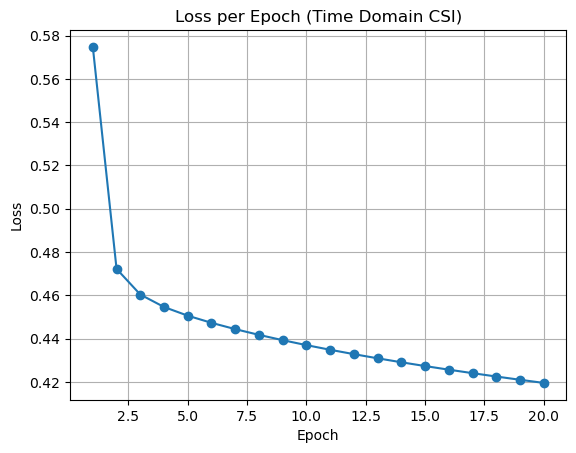

Validation Accuracy with Time Domain CSI as Input: 81.28%


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4*1632, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Time Domain CSI as INPUT
X_train_time_abs = torch.abs(train_CSI_time).view(-1, 4*1632)
X_valid_time_abs = torch.abs(valid_CSI_time).view(-1, 4*1632)

model_time = Net()
optimizer = optim.SGD(model_time.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Store loss values
loss_values_time = []

# Training
for epoch in range(20):  
    optimizer.zero_grad()
    outputs = model_time(X_train_time_abs)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    loss_values_time.append(loss.item())
    print(f'Epoch {epoch+1}/20, Loss: {loss.item()}')

# Plotting the loss for each epoch
plt.plot(range(1, 21), loss_values_time, marker='o')
plt.title('Loss per Epoch (Time Domain CSI)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluation
model_time.eval()
with torch.no_grad():
    outputs = model_time(X_valid_time_abs)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_valid).sum().item() / y_valid.size(0)
    print(f'Validation Accuracy with Time Domain CSI as Input: {accuracy * 100}%')

In [23]:
# Frequency Domain CSI as INPUT

X_train_freq_abs = torch.abs(train_CSI).view(-1, 4*1632)
X_valid_freq_abs = torch.abs(valid_CSI).view(-1, 4*1632)


model_freq = Net()
optimizer = optim.SGD(model_freq.parameters(), lr=0.001)

for epoch in range(20):  
    optimizer.zero_grad()
    outputs = model_freq(X_train_freq_abs)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{20}, Loss: {loss.item()}')

model_freq.eval()
with torch.no_grad():
    outputs = model_freq(X_valid_freq_abs)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_valid).sum().item() / y_valid.size(0)
    print(f'Validation Accuracy with Frequency Domain CSI as Input: {accuracy * 100}%')

Epoch 1/20, Loss: 9.22646427154541
Epoch 2/20, Loss: 4200.9072265625
Epoch 3/20, Loss: 29364.765625
Epoch 4/20, Loss: 384.22552490234375
Epoch 5/20, Loss: 1451709.375
Epoch 6/20, Loss: 21072.44921875
Epoch 7/20, Loss: 4240578.0
Epoch 8/20, Loss: 100411875328.0
Epoch 9/20, Loss: 2671800064.0
Epoch 10/20, Loss: 1112339755565056.0
Epoch 11/20, Loss: 4.69334234622928e+28
Epoch 12/20, Loss: 1218884864.0
Epoch 13/20, Loss: 46904792.0
Epoch 14/20, Loss: 36803380.0
Epoch 15/20, Loss: 26701980.0
Epoch 16/20, Loss: 16600580.0
Epoch 17/20, Loss: 6499191.0
Epoch 18/20, Loss: 2.2942631244659424
Epoch 19/20, Loss: 0.6620660424232483
Epoch 20/20, Loss: 0.6135373115539551
Validation Accuracy with Frequency Domain CSI as Input: 81.34%


In [22]:
# Vehicle Positioning Program
# Sol 1: Gradient Clipping

train_coords = train_dl_origin.dataset[:][1][:,:2]  
valid_coords = valid_dl_origin.dataset[:][1][:,:2]

train_coords = (train_coords - torch.mean(train_coords, dim=0)) / torch.std(train_coords, dim=0)
valid_coords = (valid_coords - torch.mean(valid_coords, dim=0)) / torch.std(valid_coords, dim=0)

class PositionNet(nn.Module):
    def __init__(self):
        super(PositionNet, self).__init__()
        self.fc1 = nn.Linear(4*1632, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)  
        self.dropout = nn.Dropout(0.5)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  
        x = self.fc3(x)  
        return x

model_position = PositionNet()
optimizer = optim.SGD(model_position.parameters(), lr=0.00001)
criterion = nn.MSELoss()

for epoch in range(20):
    optimizer.zero_grad()
    outputs = model_position(X_train_freq_abs)
    loss = criterion(outputs, train_coords)
    loss.backward()
    
    # Clip the gradient
    torch.nn.utils.clip_grad_norm_(model_position.parameters(), max_norm=1)
    
    optimizer.step()
    print(f'Epoch {epoch+1}/{20}, Loss: {loss.item()}')

Epoch 1/20, Loss: 9951.1611328125
Epoch 2/20, Loss: 10174.845703125
Epoch 3/20, Loss: 9864.24609375
Epoch 4/20, Loss: 10021.640625
Epoch 5/20, Loss: 10226.5341796875
Epoch 6/20, Loss: 10030.3154296875
Epoch 7/20, Loss: 10006.1181640625
Epoch 8/20, Loss: 10182.9150390625
Epoch 9/20, Loss: 10281.8642578125
Epoch 10/20, Loss: 9958.603515625
Epoch 11/20, Loss: 10126.013671875
Epoch 12/20, Loss: 9944.4638671875
Epoch 13/20, Loss: 10090.56640625
Epoch 14/20, Loss: 10008.7255859375
Epoch 15/20, Loss: 9907.4892578125
Epoch 16/20, Loss: 10018.5947265625
Epoch 17/20, Loss: 10089.6171875
Epoch 18/20, Loss: 9979.794921875
Epoch 19/20, Loss: 9929.177734375
Epoch 20/20, Loss: 10139.1650390625


In [23]:
model_position.eval()
with torch.no_grad():
    outputs = model_position(X_valid_freq_abs)
    loss = criterion(outputs, valid_coords)
    print(f'Validation MSE Loss after applying Gradient Clipping: {loss.item()}')

Validation MSE Loss after applying Gradient Clipping: 3198.13916015625


In [24]:
# Sol 3: Different Optimizer (Adam)

train_coords = train_dl_origin.dataset[:][1][:,:2]  
valid_coords = valid_dl_origin.dataset[:][1][:,:2]

train_coords = (train_coords - torch.mean(train_coords, dim=0)) / torch.std(train_coords, dim=0)
valid_coords = (valid_coords - torch.mean(valid_coords, dim=0)) / torch.std(valid_coords, dim=0)

class PositionNet(nn.Module):
    def __init__(self):
        super(PositionNet, self).__init__()
        self.fc1 = nn.Linear(4*1632, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)  
        self.dropout = nn.Dropout(0.5)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  
        x = self.fc3(x)  
        return x

model_position = PositionNet()

# Use Adam optimizer
optimizer = torch.optim.Adam(model_position.parameters(), lr=0.0001)

criterion = nn.MSELoss()

for epoch in range(25):
    optimizer.zero_grad()
    outputs = model_position(X_train_freq_abs)
    loss = criterion(outputs, train_coords)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{25}, Loss: {loss.item()}')


Epoch 1/25, Loss: 5277.86083984375
Epoch 2/25, Loss: 12092.0654296875
Epoch 3/25, Loss: 2444.529052734375
Epoch 4/25, Loss: 2948.5078125
Epoch 5/25, Loss: 2156.760009765625
Epoch 6/25, Loss: 1659.4815673828125
Epoch 7/25, Loss: 1515.3419189453125
Epoch 8/25, Loss: 1400.2589111328125
Epoch 9/25, Loss: 1301.748779296875
Epoch 10/25, Loss: 1244.2037353515625
Epoch 11/25, Loss: 1134.1087646484375
Epoch 12/25, Loss: 1054.011962890625
Epoch 13/25, Loss: 970.6859741210938
Epoch 14/25, Loss: 874.0671997070312
Epoch 15/25, Loss: 800.747314453125
Epoch 16/25, Loss: 725.73876953125
Epoch 17/25, Loss: 630.1710815429688
Epoch 18/25, Loss: 556.1018676757812
Epoch 19/25, Loss: 490.2467346191406
Epoch 20/25, Loss: 421.98760986328125
Epoch 21/25, Loss: 373.6336364746094
Epoch 22/25, Loss: 322.8841247558594
Epoch 23/25, Loss: 283.2504577636719
Epoch 24/25, Loss: 255.03366088867188
Epoch 25/25, Loss: 222.89892578125


In [25]:
model_position.eval()
with torch.no_grad():
    outputs = model_position(X_valid_freq_abs)
    loss = criterion(outputs, valid_coords)
    print(f'Validation MSE Loss after applying ADAM Optimizer: {loss.item()}')

Validation MSE Loss after applying ADAM Optimizer: 3.058534860610962


In [26]:
import time

start_time = time.time()

for epoch in range(20): 
    optimizer.zero_grad()
    outputs = model_position(X_train_freq_abs)
    loss = criterion(outputs, train_coords)
    loss.backward()
    optimizer.step()

end_time = time.time()

print(f'Time used for training: {end_time - start_time} seconds')

Time used for training: 27.20578145980835 seconds


In [27]:
model_size = sum(p.numel() for p in model_position.parameters() if p.requires_grad)

print(f'Size of the model: {model_size} parameters')

Size of the model: 3408770 parameters


In [28]:
import time

start_time = time.time()

for epoch in range(20): 
    optimizer.zero_grad()
    outputs = model_position(X_train_time_abs)
    loss = criterion(outputs, train_coords)
    loss.backward()
    optimizer.step()

end_time = time.time()

print(f'Time used for training: {end_time - start_time} seconds')

Time used for training: 27.17866587638855 seconds


Epoch 1/20, Loss: 0.6961142420768738
Epoch 2/20, Loss: 0.6888054609298706
Epoch 3/20, Loss: 0.6821237206459045
Epoch 4/20, Loss: 0.6759026050567627
Epoch 5/20, Loss: 0.6700983047485352
Epoch 6/20, Loss: 0.6645923852920532
Epoch 7/20, Loss: 0.6593008637428284
Epoch 8/20, Loss: 0.6541260480880737
Epoch 9/20, Loss: 0.6490367650985718
Epoch 10/20, Loss: 0.6440251469612122
Epoch 11/20, Loss: 0.6390759348869324
Epoch 12/20, Loss: 0.6341774463653564
Epoch 13/20, Loss: 0.6293302774429321
Epoch 14/20, Loss: 0.6245355010032654
Epoch 15/20, Loss: 0.6197883486747742
Epoch 16/20, Loss: 0.6150892376899719
Epoch 17/20, Loss: 0.6104378700256348
Epoch 18/20, Loss: 0.6058350801467896
Epoch 19/20, Loss: 0.6012795567512512
Epoch 20/20, Loss: 0.5967685580253601


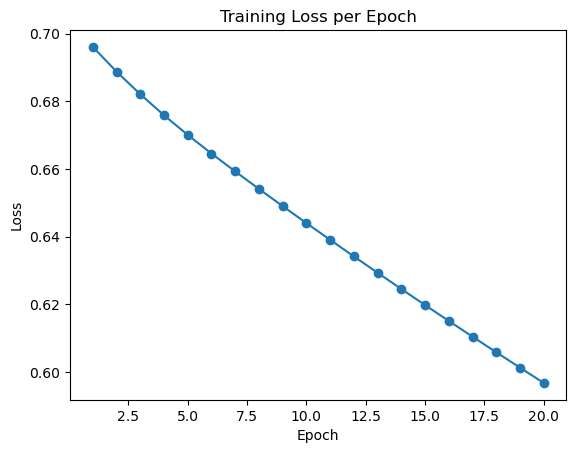

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4 * 1632, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, optimizer, and loss function
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Adjust learning rate
criterion = nn.CrossEntropyLoss()

# Prepare data
X_train = train_CSI_normalize.view(-1, 4 * 1632)
y_train = train_label
X_valid = valid_CSI_normalize.view(-1, 4 * 1632)
y_valid = valid_label

# Training
losses = []
for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    print(f'Epoch {epoch+1}/20, Loss: {loss.item()}')

# Plotting the loss
plt.plot(range(1, 21), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.show()

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Flatten the CSI matrices for KNN
X_train_knn = train_CSI_normalize.view(train_CSI_normalize.size(0), -1).numpy()
X_valid_knn = valid_CSI_normalize.view(valid_CSI_normalize.size(0), -1).numpy()

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_knn, y_train.numpy())

y_pred_knn = knn.predict(X_valid_knn)

accuracy_knn = accuracy_score(y_valid.numpy(), y_pred_knn)
print(f'Validation Accuracy (KNN): {accuracy_knn * 100}%')

Validation Accuracy (KNN): 99.96000000000001%


In [31]:
# Decision Tree
tree = DecisionTreeClassifier()
tree.fit(X_train_flat, y_train_np)
y_pred_tree = tree.predict(X_valid_flat)
accuracy_tree = accuracy_score(y_valid_np, y_pred_tree)
print(f'Validation Accuracy (Decision Tree): {accuracy_tree * 100}%')

Validation Accuracy (Decision Tree): 95.32000000000001%


In [32]:
# Random Forest
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train_flat, y_train_np)
y_pred_forest = forest.predict(X_valid_flat)
accuracy_forest = accuracy_score(y_valid_np, y_pred_forest)
print(f'Validation Accuracy (Random Forest): {accuracy_forest * 100}%')

Validation Accuracy (Random Forest): 99.32%
